# Финальный проект. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## 1. Исследовательский анализ данных

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from catboost import CatBoostRegressor

In [76]:
pd.set_option('display.max_columns', None)

**data_arc**

In [77]:
data_arc = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_arc.csv')
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [78]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Как можем видеть, в данных нет пропущенных значений. Визуализируем и проверим, есть ли артефакты

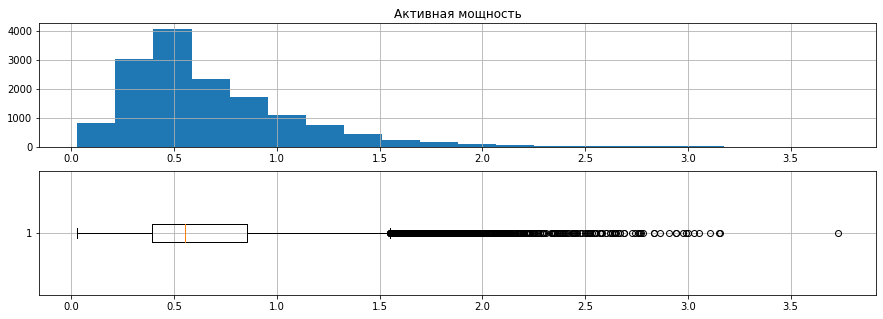

In [79]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.hist(data_arc['Активная мощность'], bins=20)
plt.grid()
plt.title('Активная мощность')
plt.subplot(212)
plt.boxplot(data_arc['Активная мощность'], vert=False)
plt.grid()
plt.show()

Видим явное обособленное значение. Пусть я и не физик и не могу сказать, является ли корректным значение активной мощности после 3.5, но такие одинокие значения могу запутать модель в будушем.

Избавимся от данного показателя

In [80]:
data_arc = data_arc[data_arc['Активная мощность'] < 3.5]

Визуализируем реактивную мощность

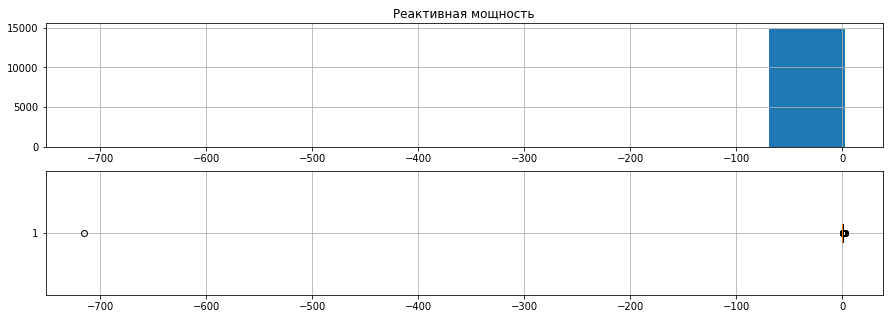

In [81]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.hist(data_arc['Реактивная мощность'])
plt.grid()
plt.title('Реактивная мощность')
plt.subplot(212)
plt.boxplot(data_arc['Реактивная мощность'], vert=False)
plt.grid()
plt.show()

Видим, что все значения распределены около одного значения. Т.к это значение одно, то вероятнее всего это артефак или какой-то супер особый случай. Избавимся от артефакта

In [82]:
data_arc = data_arc[data_arc['Реактивная мощность'] > -700]

Загрузим следующую таблицу

**data_bulk**

In [83]:
data_bulk = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_bulk.csv')
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [84]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Значения даны не для всех key. Стоит предположить, что для пропущенных key не добавляли вещества совсем.

Поскольку химические вещества являются **дорогостоящими**, их стоит учитывать при обучении модели машинного обучения.

Посмотрим на распределения каждой из добавок.

/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


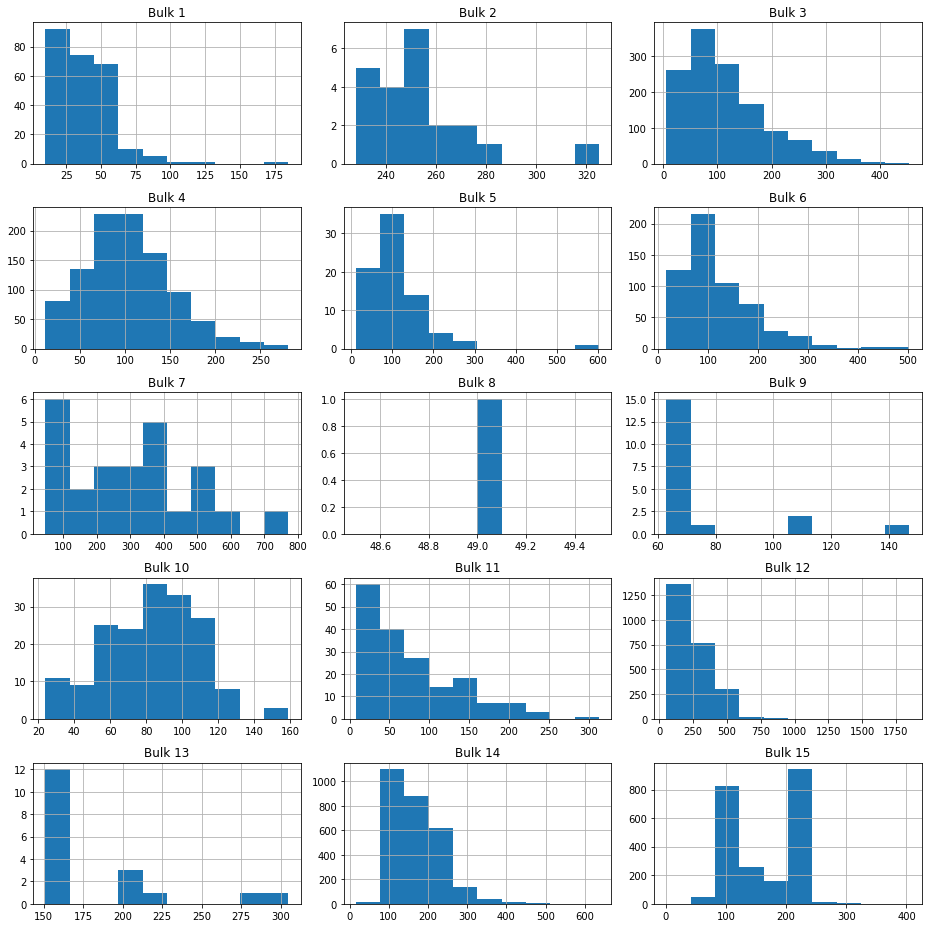

In [85]:
plt.figure(figsize=(13,13))
for i in range(1, 16):
    plt.subplot(5, 3, i)
    plt.hist(data_bulk[data_bulk != 0]['Bulk {}'.format(i)])
    plt.title('Bulk {}'.format(i))
    plt.tight_layout()
    plt.grid()
plt.show()

Ничего подозрительного нет

Похоже, что Nan стоят там где не вообще не добавляли добавки. Заменим пропущенные значения на 0

In [86]:
data_bulk.fillna(0, inplace=True)
data_bulk.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


**data_bulk_time**

In [87]:
data_bulk_time = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_bulk_time.csv')
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Таблица похожа на Bulk. Здесь вместо количества материала указано время добавки. Кажется, что сложно будет выжать из этого какую-то полезность, но все равно предобработаем - заменим NaN на нули

In [88]:
data_bulk_time.fillna(0, inplace=True)
data_bulk.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


Загрузим следующую таблицу

**data_gas**

In [89]:
data_gas = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_gas.csv')
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


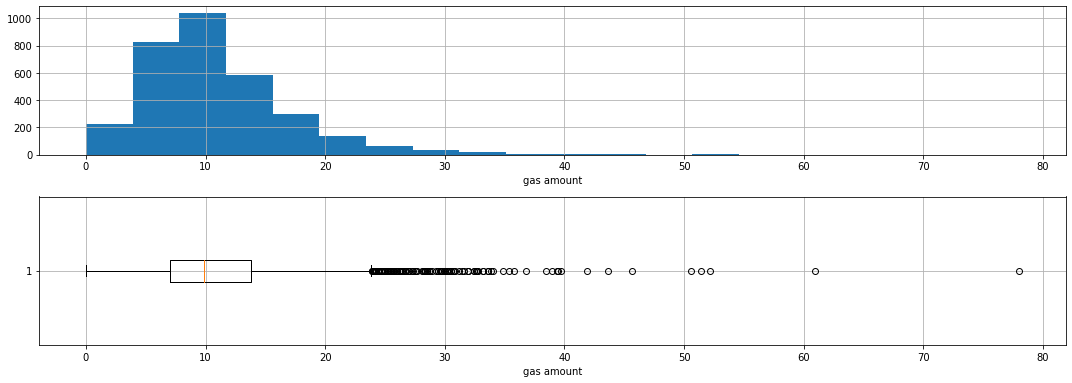

In [90]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.hist(data_gas['Газ 1'], 20)
plt.xlabel('gas amount')
plt.grid()
plt.tight_layout()
plt.subplot(212)
plt.boxplot(data_gas['Газ 1'], vert=False)
plt.xlabel('gas amount')
plt.grid()
plt.show()

Боксплот показывает, что есть некоторые аномальные значения. Стоило бы обратиться к инженеру (или кому-то кто разбирается в предметной области) и узнать, нормально ли иметь в данных показателях значение больше 23. Если модель машинного обучения выдаст удовлетворяющий результат, то не будем избавляться от аномалий (т.к в целом данных мало).

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
хорошо

Загрузим следующие данные

**data_wire**

In [91]:
data_wire = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_wire.csv')
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Тут ситуация схожа на Bulk

In [92]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yakovlev/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


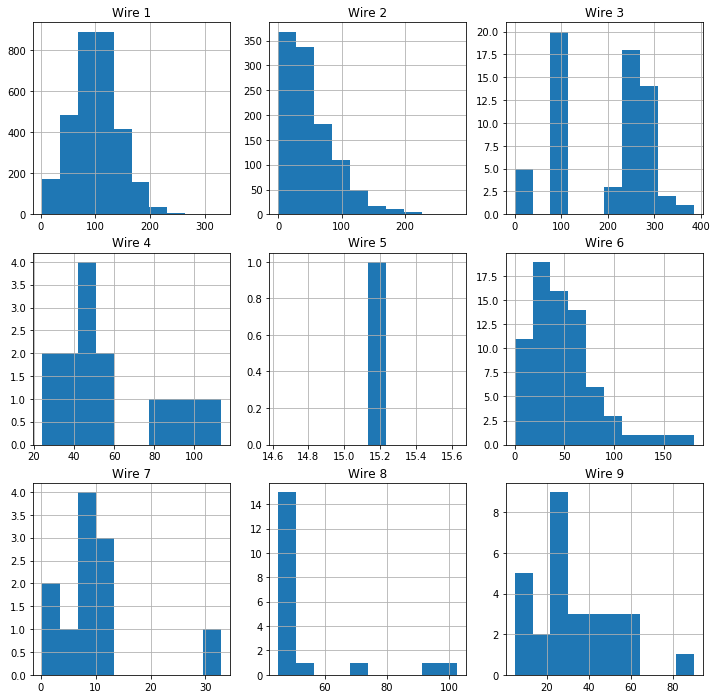

In [93]:
plt.figure(figsize=(12,12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.hist(data_wire['Wire {}'.format(i)])
    plt.title('Wire {}'.format(i))
    plt.grid()
plt.show()

Вероятно, что ситуация с проволкой такая же, как и Bulk. Т.е проволка достаточно дорогостоящая, поэтому стоит учитывать данный показатель при построении модели. Поэтому даже Wire 5, где всего лишь один показатель, не будем удалять

Посмотрим на следующую таблицу

**data_wire_time**

In [94]:
data_wire_time = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_wire_time.csv')
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данная таблица - аналог предыдущей. Отличие лишь в том, что тут написано не количество добавленной проволки, а время ее добавления. Не думаю, что время добавления сильно поможет улучшить результаты обучения модели, но все равно заполним пропущенные значения нулями.

In [95]:
data_wire_time.fillna(0, inplace=True)
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:46:10,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:13:47,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:48:05,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,0,0,0,0,0,0,0


Следующие данные

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
ок

**data_temp**

In [96]:
data_temp = pd.read_csv('/Users/yakovlev/Downloads/final_steel/data_temp.csv')
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Данная таблица является одной из основополагающих для результатов обучения. Здесь мы сможем извлечь целевой признак - финальную температуру и, скорее всего, наиболее коррелирующий с ним - температуру до начала нагреваний.

In [97]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Как можем видеть, в таблице содержатся пропуски. Посмотрим на последние 5 строк таблицы

In [98]:
data_temp.tail()

,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


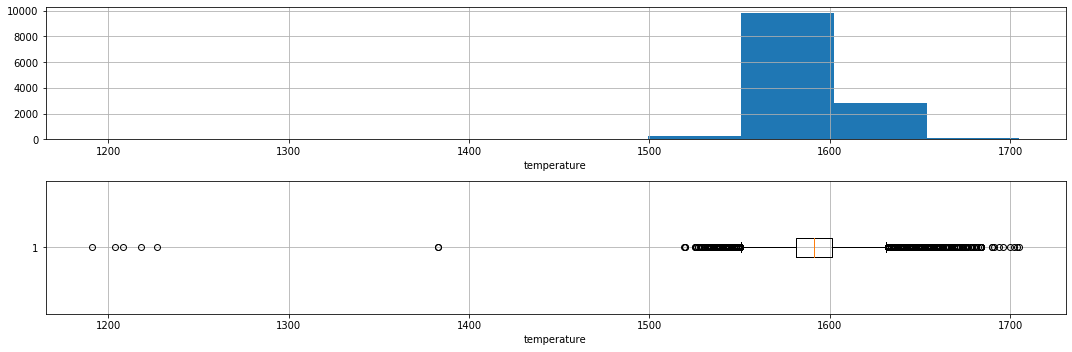

In [99]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.hist(data_temp['Температура'].dropna())
plt.grid()
plt.xlabel('temperature')
plt.subplot(212)
plt.boxplot(data_temp.dropna()['Температура'], vert=False)
plt.grid()
plt.xlabel('temperature')
plt.tight_layout()
plt.show()

Видим небольшие аномальные значения. В процессе обучения модели выясним, ухудшают ли они качество обучения или нет

Дропнем пропущенные значения. Это можно сделать, т.к заполнить их не выйдет, а без начальной и финальной температуры ничего не получится предсказать.

In [100]:
data_temp.dropna(inplace=True)
data_temp = data_temp.reset_index(drop=True)
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br> ОК, это верно заметил!<br>
    
Что касается данного проекта: смотри, у нас измерения по партиям. Предположим, что у нас 5 измерений было в ней. И одно из них - последнее - не записалось в базу, а четыре - есть. И вот тут важный момент: если мы удалим только строку, то оставим 4 измерения в работе, но конечная температура в этой партии не будет отражать конечную температуру всй партии, т.е. мы получим искажения для моделирования. Поэтому, тут так: надо организовывать код так, чтобы удалять всю партию, где нет конечного измерения температуры.<br>

Но в этом проекте данные такие, что обыкновенной dropna хватило)
<font color='red'>
Но тогда, также, надо проверить случаи, когда в партии только одно измерение. Т.е. начальная температура = конечной. И такие строки тоже исключить

В итоге сведем все исследования в план

### План выполнения работы

- [ ] Подготовка данных
    - [ ] Выделены нужные фичи, а также таргет
    - [ ] Выполнена работа с аномальными и пропущенными данными
    - [ ] Данные разбиты на тренировочную и тестовую выборки
    - [ ] Произведена стандартизация данных
- [ ] Построение модели
    - [ ] Построена базовая модель
    - [ ] Предсказано MAE
    - [ ] Изучена возможность добавления новых фичей для повышения MAE
    - [ ] В процессе были задействованы различные модели ML (линейная регрессия, бустинги)
    - [ ] Был произведен подбор наилучших гиперпараметров
- [ ] Выводы

## 2. Подготовка признаков

In [101]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [102]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13006 entries, 0 to 13005
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13006 non-null  int64  
 1   Время замера  13006 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 305.0+ KB


Создадим два списка. В один будем добавлять индекс первоначальной температуры. Во второй конечной.

In [103]:
last_idx_list = []
first_idx_list = [0]
for i in range(data_temp.shape[0] - 1):
    if data_temp.iloc[i]['key'] != data_temp.iloc[i+1]['key']:
        last_idx_list.append(i)
        first_idx_list.append(i + 1)
last_idx_list.append(data_temp.shape[0] - 1)

In [104]:
print(len(first_idx_list), len(last_idx_list))

3216 3216


Теперь в датафрейме укажем температуру, у которой индекс указан в last_idx_list - списке предназначенном для индексов итоговой температуры

In [105]:
prepared_data = pd.DataFrame(data_temp.iloc[last_idx_list][['key', 'Температура']]).reset_index(drop=True)
prepared_data.columns = ['key', 'Итоговая температура']
prepared_data.head()

,key,Итоговая температура
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0


Сделаем то же самое, но для начальной температуры

In [106]:
temprorary = pd.DataFrame(data_temp.iloc[first_idx_list][['key', 'Температура']]).reset_index(drop=True)
temprorary.columns = ['key', 'Начальная температура']
temprorary.head()

,key,Начальная температура
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0


Объединим данные

In [107]:
prepared_data = prepared_data.merge(temprorary, on='key')

In [108]:
data_arc.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285


Добавим новый столбец, в котором укажем время нагревания, но для начала переведем две фичи в datetime формат

In [109]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Теперь мы можем вычесть из одной даты другую и перевести все в секунды. Работает примерно так

In [110]:
(data_arc['Конец нагрева дугой'][1] - data_arc['Начало нагрева дугой'][1]).total_seconds()

185.0

Реализуем через метод apply

In [111]:
data_arc['Время нагревания (сек)'] = data_arc.apply(
    lambda row: (row['Конец нагрева дугой'] - row['Начало нагрева дугой']).total_seconds(), axis=1)
    

Сгруппируем данные по столбцу key и посчитаем среднее время нагревания, а также количество нагреваний. Сохраним данные в pivot_data

In [112]:
pivot_data = data_arc.pivot_table(['Активная мощность', 'Реактивная мощность', 'Время нагревания (сек)'], 'key', aggfunc=['mean', 'count'])
pivot_data.columns = ['Активная мощность', 'Время нагревания (сек)', 'Реактивная мощность', 'Количество нагревов', '_1', '_2']
pivot_data.drop(['_1', '_2'], axis=1, inplace=True)
pivot_data.head()

,Активная мощность,Время нагревания (сек),Реактивная мощность,Количество нагревов
key,,,,
1,0.975629,219.60,0.636648,5
2,0.763150,202.75,0.499528,4
3,0.505176,131.00,0.319815,5
4,0.802313,185.25,0.515074,4
5,0.836793,217.25,0.563161,4


<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br> новые факторы - могут быть значимыми, ок. Вопрос только в том - стоит ли их все тянуть в модель - не будет ли мультиколлинеарности. Например все мощности коррелируют между собой? если да - то не стоит их вместе использовать...

Теперь замерджим prepared_data и pivot_data по значению key

In [113]:
prepared_data = prepared_data.merge(pivot_data, on='key')
prepared_data.head()

,key,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Реактивная мощность,Количество нагревов
0,1,1613.0,1571.0,0.975629,219.60,0.636648,5
1,2,1602.0,1581.0,0.763150,202.75,0.499528,4
2,3,1599.0,1596.0,0.505176,131.00,0.319815,5
3,4,1625.0,1601.0,0.802313,185.25,0.515074,4
4,5,1602.0,1576.0,0.836793,217.25,0.563161,4


In [114]:
data_arc.head(2)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагревания (сек)
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0


Теперь добавим время остывания. Используя следующий цикл

In [115]:
key_sec_dataframe = pd.DataFrame([], columns=['key', 'sec'])
for i in range(data_arc.shape[0] - 1):
    if data_arc.iloc[i]['key'] == data_arc.iloc[i+1]['key']:
        seconds = (data_arc.iloc[i+1]['Начало нагрева дугой'] - data_arc.iloc[i]['Конец нагрева дугой']).total_seconds()
        key_sec_dataframe = key_sec_dataframe.append({'key': data_arc.iloc[i]['key'],
                                                     'sec': seconds}, ignore_index=True)
    if (data_arc.iloc[i]['key'] != data_arc.iloc[i-1]['key']) & (data_arc.iloc[i]['key'] != data_arc.iloc[i+1]['key']):
        key_sec_dataframe = key_sec_dataframe.append({'key': data_arc.iloc[i]['key'],
                                                     'sec': 0}, ignore_index=True)

In [116]:
key_sec_dataframe.head()

,key,sec
0,1.0,86.0
1,1.0,71.0
2,1.0,218.0
3,1.0,110.0
4,2.0,139.0


Сгруппируем полученный датафрейм по фиче key и посчитаем сумммарное время остывания в секундах

In [117]:
key_sec_gprd = key_sec_dataframe.groupby('key').sum().reset_index()
key_sec_gprd

,key,sec
0,1.0,485.0
1,2.0,333.0
2,3.0,870.0
3,4.0,352.0
4,5.0,493.0
...,...,...
3209,3237.0,441.0
3210,3238.0,364.0
3211,3239.0,1714.0
3212,3240.0,2685.0


Замерджим prepared_data и полученную таблицу, а также изменим названия фичей

In [118]:
prepared_data = prepared_data.merge(key_sec_gprd, on='key')
prepared_data = prepared_data.rename({'sec': 'Суммарное время остывания'}, axis=1)
prepared_data.head()

,key,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Реактивная мощность,Количество нагревов,Суммарное время остывания
0,1,1613.0,1571.0,0.975629,219.60,0.636648,5,485.0
1,2,1602.0,1581.0,0.763150,202.75,0.499528,4,333.0
2,3,1599.0,1596.0,0.505176,131.00,0.319815,5,870.0
3,4,1625.0,1601.0,0.802313,185.25,0.515074,4,352.0
4,5,1602.0,1576.0,0.836793,217.25,0.563161,4,493.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ОК

**data_bulk**

In [119]:
data_bulk.head(2)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


Как было сказано раньше, несмотря на то, что в таблице Bulk много нулевых значений, добавим эту таблицу в полном объеме к основной (материалы из Bulk дорого стоят поэтому учтем их в полном объеме)

In [120]:
prepared_data = prepared_data.merge(data_bulk, on='key')
prepared_data.head()

,key,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Реактивная мощность,Количество нагревов,Суммарное время остывания,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,1613.0,1571.0,0.975629,219.60,0.636648,5,485.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,1602.0,1581.0,0.763150,202.75,0.499528,4,333.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,1599.0,1596.0,0.505176,131.00,0.319815,5,870.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,1625.0,1601.0,0.802313,185.25,0.515074,4,352.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,1602.0,1576.0,0.836793,217.25,0.563161,4,493.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


**data_bulk_time**

Пока что не будем добавалять данные о времени добавления добавок - не совсем понятно как исользовать эту информацию. Если качество не будет дотягивать до нужных чисел,  то подумаем о добавлении информации из data_bulk_time.

Перейдем к data_gas

**data_gas**

In [121]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Просто склеим данные с основными

In [122]:
prepared_data = prepared_data.merge(data_gas)
prepared_data.head()

,key,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Реактивная мощность,Количество нагревов,Суммарное время остывания,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1613.0,1571.0,0.975629,219.60,0.636648,5,485.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1602.0,1581.0,0.763150,202.75,0.499528,4,333.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1599.0,1596.0,0.505176,131.00,0.319815,5,870.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1625.0,1601.0,0.802313,185.25,0.515074,4,352.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1602.0,1576.0,0.836793,217.25,0.563161,4,493.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


Добавим последнюю таблицу - data_wire

**data_wire**

Заменим пропущенные значения на нули. Если указан - значит не добавляли

In [123]:
data_wire.fillna(0, inplace=True)

Замерджим данные

In [124]:
prepared_data = prepared_data.merge(data_wire)

В итоге получили следующую таблицу

In [125]:
prepared_data.head()

,key,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Реактивная мощность,Количество нагревов,Суммарное время остывания,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1613.0,1571.0,0.975629,219.60,0.636648,5,485.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1602.0,1581.0,0.763150,202.75,0.499528,4,333.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1599.0,1596.0,0.505176,131.00,0.319815,5,870.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1625.0,1601.0,0.802313,185.25,0.515074,4,352.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1602.0,1576.0,0.836793,217.25,0.563161,4,493.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


На консультации, тимлид сказал, что реактивная мощность не оказывает влияния на итоговую температуру. Посмотрим на корреляцию между этими признаками и убедимся (или нет) в его словах

In [126]:
prepared_data['Итоговая температура'].corr(prepared_data['Реактивная мощность'])

-0.09925560269645271

Действительно, корреляция сильно низкая, избавимся от данного признака, а также от значения key - он больше не понадобится.

In [127]:
prepared_data = prepared_data.drop(['key', 'Реактивная мощность'], axis=1)

Для обучения модели у нас должны быть разные показатели в фичах "Итоговая температура" и "Начальная температура". Поэтому подкорректируем датасет

In [128]:
prepared_data = prepared_data[prepared_data['Итоговая температура'] != prepared_data['Начальная температура']]

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>отлично, писал об этом выше. Тогда тот комментарий можно считать не действиетльным)

In [129]:
prepared_data.head()

,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Количество нагревов,Суммарное время остывания,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1613.0,1571.0,0.975629,219.60,5,485.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,0.763150,202.75,4,333.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,0.505176,131.00,5,870.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1625.0,1601.0,0.802313,185.25,4,352.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,0.836793,217.25,4,493.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2328
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Итоговая температура       2293 non-null   float64
 1   Начальная температура      2293 non-null   float64
 2   Активная мощность          2293 non-null   float64
 3   Время нагревания (сек)     2293 non-null   float64
 4   Количество нагревов        2293 non-null   int64  
 5   Суммарное время остывания  2293 non-null   float64
 6   Bulk 1                     2293 non-null   float64
 7   Bulk 2                     2293 non-null   float64
 8   Bulk 3                     2293 non-null   float64
 9   Bulk 4                     2293 non-null   float64
 10  Bulk 5                     2293 non-null   float64
 11  Bulk 6                     2293 non-null   float64
 12  Bulk 7                     2293 non-null   float64
 13  Bulk 8                     2293 non-null   float

Проверим даннные на мультиколлинеарность, для это построим матрицу коллинеарности

In [131]:
prepared_data.corr()

,Итоговая температура,Начальная температура,Активная мощность,Время нагревания (сек),Количество нагревов,Суммарное время остывания,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Итоговая температура,1.000000,0.247758,0.209481,0.191402,0.179089,0.045555,-0.074559,-0.083292,-0.036533,0.184636,-0.028678,-0.179633,-0.108353,-0.026855,-0.016259,0.061691,-0.110517,0.265241,-0.011054,0.113165,0.266348,0.058063,0.313493,-0.206883,-0.048049,-0.161311,NaN,-0.084906,-0.138618,-0.010898,-0.027792
Начальная температура,0.247758,1.000000,-0.407870,-0.350382,-0.143991,0.229067,0.073896,0.120302,-0.104162,0.142999,0.068947,-0.095032,0.075107,-0.009264,-0.026013,0.035791,-0.087717,-0.061164,0.018910,-0.132640,-0.041960,0.037686,0.207442,-0.084844,0.000232,0.065347,NaN,0.020325,0.044967,-0.023055,0.004645
Активная мощность,0.209481,-0.407870,1.000000,0.947599,0.029601,-0.050555,0.030549,-0.039708,0.057273,-0.039862,-0.049548,0.043150,-0.044677,-0.008249,-0.010068,-0.017802,0.038786,0.389382,-0.003861,0.347830,0.341214,0.095524,-0.099614,-0.008146,0.004837,-0.040417,NaN,0.036870,-0.032663,-0.007785,0.002067
Время нагревания (сек),0.191402,-0.350382,0.947599,1.000000,-0.006031,-0.054936,0.050640,-0.042441,0.019501,-0.039540,-0.044529,0.047378,-0.048307,-0.007952,-0.028166,-0.031823,0.046672,0.368479,-0.000759,0.335189,0.282812,0.100762,-0.109675,-0.018711,-0.003888,-0.044897,NaN,0.013267,-0.031801,-0.027116,0.010649
Количество нагревов,0.179089,-0.143991,0.029601,-0.006031,1.000000,0.540320,0.101220,0.093605,0.107128,-0.005878,0.075317,0.153588,0.153493,-0.009088,0.038355,0.007550,0.067116,0.304969,0.112670,0.334650,0.172922,0.404286,0.137288,0.080412,0.055424,0.114364,NaN,0.053539,0.074152,0.044072,-0.024965
Суммарное время остывания,0.045555,0.229067,-0.050555,-0.054936,0.540320,1.000000,0.140479,0.283836,0.011466,0.005819,0.113328,0.140444,0.247855,-0.001298,-0.004980,-0.003419,0.021519,0.149804,0.270636,0.116970,0.075635,0.407885,0.156342,0.054273,0.071210,0.276491,NaN,0.148781,0.170471,-0.000988,-0.000828
Bulk 1,-0.074559,0.073896,0.030549,0.050640,0.101220,0.140479,1.000000,0.226159,-0.010652,0.041917,0.060744,-0.005339,0.238760,-0.005780,-0.019948,-0.023044,-0.037009,0.327637,-0.010411,0.208215,-0.000323,0.239360,0.015794,-0.011764,0.020315,0.147235,NaN,0.149481,0.083979,-0.019725,0.011065
Bulk 2,-0.083292,0.120302,-0.039708,-0.042441,0.093605,0.283836,0.226159,1.000000,-0.047407,0.041288,0.360219,-0.030261,0.679332,-0.001570,-0.005417,-0.018235,0.001837,-0.099758,-0.005681,-0.141981,-0.106577,0.218583,-0.170400,-0.039388,0.223100,0.699320,NaN,0.558837,0.431723,-0.005357,-0.006950
Bulk 3,-0.036533,-0.104162,0.057273,0.019501,0.107128,0.011466,-0.010652,-0.047407,1.000000,-0.294200,-0.007302,0.066254,-0.033898,0.020839,0.011106,-0.085609,-0.008658,0.018912,-0.013751,0.010684,-0.013031,0.057472,0.040465,0.096544,0.005347,-0.040974,NaN,0.006699,-0.019663,0.004588,0.004278
Bulk 4,0.184636,0.142999,-0.039862,-0.039540,-0.005878,0.005819,0.041917,0.041288,-0.294200,1.000000,0.028852,-0.250883,0.046405,-0.013239,-0.002791,-0.085481,-0.117665,0.104344,0.003414,-0.090557,0.102593,0.016853,0.295424,-0.266983,-0.039247,0.034843,NaN,-0.011236,0.034164,0.008061,-0.058371


В итоге видим сильные корреляции между следующими признаками:
    - Активная мощность - Время нагревания (сек)
Избавимся от признака "Активная мощность", т.к два высококоррелирующих признака могу запутать модель и она ухудшит свое качество

In [132]:
prepared_data =  prepared_data.drop('Активная мощность', axis=1)

## 3. Обучение модели

Разобьем датасет на трейн и тест выборку в соотношении 1/4

In [133]:
y = prepared_data['Итоговая температура']
X = prepared_data.drop('Итоговая температура', axis=1)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тест выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (1719, 29) (1719,)
Размер тест выборки: (574, 29) (574,)


In [135]:
X_train.head()

,Начальная температура,Время нагревания (сек),Количество нагревов,Суммарное время остывания,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
31,1602.0,250.500000,4,1896.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.0,0.0,257.0,154.0,14.881404,105.225121,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132,1588.0,190.333333,3,254.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,0.0,102.0,203.0,5.666654,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2287,1562.0,199.500000,4,456.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,144.0,204.0,8.031278,118.154396,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1157,1615.0,155.333333,3,941.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.827437,202.222794,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,1605.0,202.666667,6,1443.0,0.0,0.0,146.0,0.0,0.0,125.0,0.0,0.0,0.0,0.0,0.0,408.0,0.0,215.0,203.0,11.024942,110.292000,45.135998,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучим модель линейной регресси и бустинг и посмотрим на результат

In [136]:
model = LinearRegression()

In [137]:
scorer = make_scorer(mean_absolute_error)

In [138]:
cross_val_score(model, X_train, y_train, verbose=0, scoring=scorer, cv=3).mean()

6.868354691381469

In [139]:
model = CatBoostRegressor(verbose=0, random_state=123, iterations=4000, learning_rate=0.01, early_stopping_rounds=5, depth=6)

In [140]:
cross_val_score(model, X_train, y_train, verbose=0, scoring=scorer, cv=3).mean()

6.132086565287907

Результат удовлетворяет, не будем возвращаться к возможным выбросам (тем более данных осталось совсем немного)

Посмотрим на результат на тестовой выборке.

In [141]:
model.fit(X_train, y_train)

In [142]:
mean_absolute_error(model.predict(X_test), y_test)

5.642339769565462

Выведем график важности признаков, для этого сначала получим важность признаков через feature_importances_

In [143]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head()

,importance
feature,
Начальная температура,20.185
Время нагревания (сек),15.279
Количество нагревов,13.305
Суммарное время остывания,8.315
Wire 1,7.009


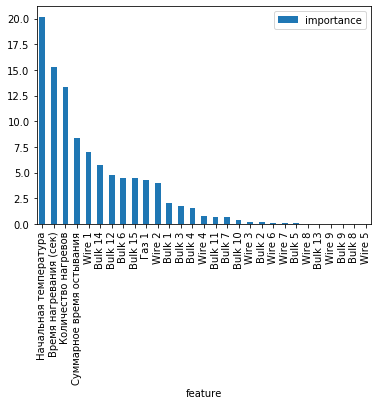

In [144]:
importances.plot.bar()

Как можем видеть, добавленные метрики сильно помогли с результатами обучения, все они находятся в топе по важности. Bulk не сильно влияют на модель, но там и данных было всего ничего...

## 4. Вывод

В результате получили достаточно низкое значение MAE. Кажется, был произведен достаточно качественный feature engineering, из-за которого было достигнуто такое значение MAE.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
И снова доброго дня, Владислав)<br>
ОК, увидел твои доработки, хорошо.<br>
Интересно получилось, мощность ни где не фигурирует..<br>
Может, конечно, возникнуть вопрос: мы же хотим уменьшать энергопотребление - где же хоть одна характеристика, связанная с электричеством? Тут нужно быть готовым ответить на этот вопрос.<br>
Справедливость ради, скажу, что часто оставляют именно мощность. Тогда вопрос выше - снимется..<br> 
А можно ввести фактор работы - чтобы объединить и время и мощность.<br>

Здесь, наверное, стоит вот ещё что заметить: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br>
 
<font color='green'>

Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю найти себя в этой профессии!
<br>
</font>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Владислав, скажу, что качественная, уверенная работа, на мой взгляд)<br>
Обработка данных, модельная работа, конечные результаты - многое удалось как надо. Действительно - качественная подготовка данных.<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br> . Осталось лишь несколько вопросов с моей стороны))<br>
<font color='red'>    
1) При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы модели имеют сильную корреляцию друг с другом).Есть ли она у нас?  Если есть - надо  решать по понятиям:)<br><br>
    
2) Попробуй с помощью команды feature_importances_ выводить график важности факторов. Отличная вещь будет: высока яметрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала.
Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют.<br>
    
<font color='green'>
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто эти два пункта - важный момент в алгоритме моделирования. И хотелось, чтобы они у тебя остались в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.